In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from sklearn.svm import SVC

font = {'family': 'MicroSoft YaHei',
        'weight': 'bold',
        'size': 'larger'}
(plt.rc("font", family='MicroSoft YaHei', weight="bold"))

In [15]:
# ======================== PCA 类 ========================
class PCA:
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov = np.cov(X_centered, rowvar=False)
        U, S, Vt = np.linalg.svd(cov)
        self.components = Vt

    def transform(self, X, dim):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components[:dim].T)

In [16]:
# ======================== LDA 类 ========================
class LDA:
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_features = X.shape[1]
        mean_overall = np.mean(X, axis=0)

        Sw = np.zeros((n_features, n_features))
        Sb = np.zeros((n_features, n_features))

        for c in self.classes:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            Sw += np.dot((X_c - mean_c).T, (X_c - mean_c))
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(-1, 1)
            Sb += n_c * mean_diff @ mean_diff.T

        eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw) @ Sb)
        sorted_indices = np.argsort(-eigvals.real)
        self.components = eigvecs[:, sorted_indices].T.real

    def transform(self, X, dim):
        return np.dot(X, self.components[:dim].T)

In [17]:
# ======================== KNN 类 ========================
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_indices = distances.argsort()[:self.k]
            k_labels = self.y_train[k_indices]
            y_pred.append(np.bincount(k_labels).argmax())
        return np.array(y_pred)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [18]:
# 读取数据
x = io.loadmat('Yale_64x64.mat')
ins_perclass, class_number, train_test_split = 11, 15, 9
input_dim = x['fea'].shape[1]
feat = x['fea'].reshape(-1, ins_perclass, input_dim)
label = x['gnd'].reshape(-1, ins_perclass)

train_data = feat[:, :train_test_split, :].reshape(-1, input_dim)
test_data = feat[:, train_test_split:, :].reshape(-1, input_dim)
train_label = label[:, :train_test_split].reshape(-1)
test_label = label[:, train_test_split:].reshape(-1)

In [ ]:
# ======================== PCA 降维 ========================
pca = PCA()
pca.fit(train_data)
train_pca = pca.transform(train_data, dim=8)
test_pca = pca.transform(test_data, dim=8)

# 可视化前8个特征向量
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for i in range(8):
    axes[i//4, i%4].imshow(pca.components[i].reshape(64, 64), cmap='gray')
    axes[i//4, i%4].set_title(f'PCA {i+1}')
plt.tight_layout()
plt.savefig("result/pca_basis.png")

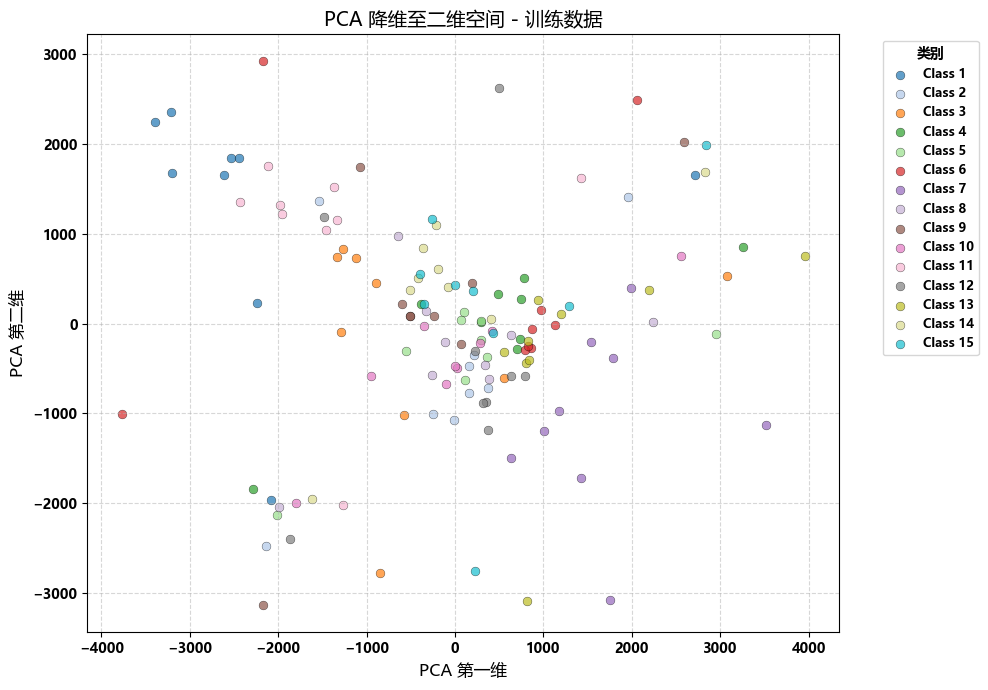

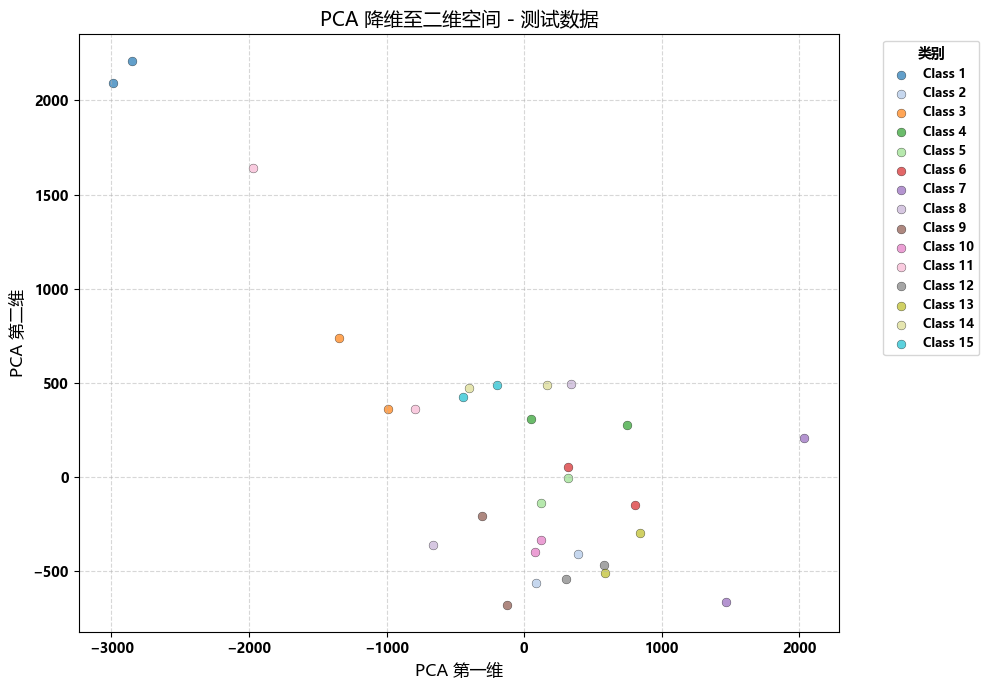

In [7]:
# PCA 降维到 2D 可视化 - 训练数据
pca_2d_train = pca.transform(train_data, dim=2)

plt.figure(figsize=(10, 7))
colors = plt.colormaps.get_cmap('tab20')

for i in range(class_number):
    start = i * train_test_split
    end = (i + 1) * train_test_split
    plt.scatter(pca_2d_train[start:end, 0], pca_2d_train[start:end, 1],
                label=f'Class {i+1}', color=colors(i / class_number), s=40, alpha=0.7, edgecolors='k', linewidths=0.3)

plt.title("PCA 降维至二维空间 - 训练数据", fontsize=14)
plt.xlabel("PCA 第一维", fontsize=12)
plt.ylabel("PCA 第二维", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title="类别")
plt.tight_layout()
plt.savefig("result/pca_2d_train.png", dpi=300)
plt.show()

# PCA 降维到 2D 可视化 - 测试数据
pca_2d_test = pca.transform(test_data, dim=2)

plt.figure(figsize=(10, 7))
for i in range(class_number):
    start = i * (ins_perclass - train_test_split)
    end = (i + 1) * (ins_perclass - train_test_split)
    plt.scatter(pca_2d_test[start:end, 0], pca_2d_test[start:end, 1],
                label=f'Class {i+1}', color=colors(i / class_number), s=40, alpha=0.7, edgecolors='k', linewidths=0.3)

plt.title("PCA 降维至二维空间 - 测试数据", fontsize=14)
plt.xlabel("PCA 第一维", fontsize=12)
plt.ylabel("PCA 第二维", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title="类别")
plt.tight_layout()
plt.savefig("result/pca_2d_test.png", dpi=300)
plt.show()

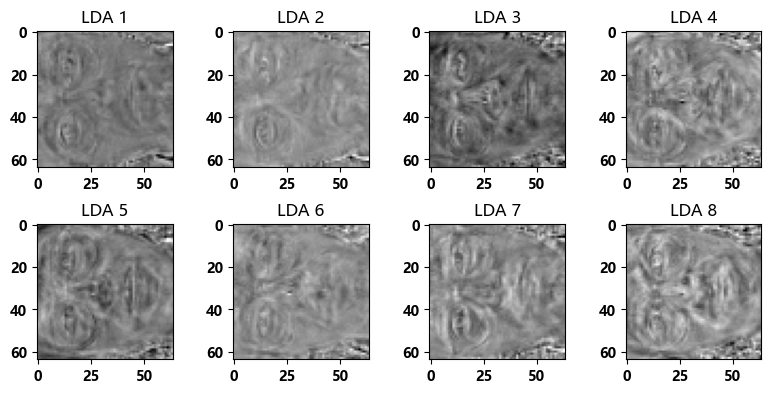

In [8]:
# ======================== LDA 降维 ========================
lda = LDA()
lda.fit(train_data, train_label)
train_lda = lda.transform(train_data, dim=8)
test_lda = lda.transform(test_data, dim=8)

# 可视化前8个特征向量
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for i in range(8):
    axes[i//4, i%4].imshow(lda.components[i].reshape(64, 64), cmap='gray')
    axes[i//4, i%4].set_title(f'LDA {i+1}')
plt.tight_layout()
plt.savefig("result/lda_basis.png")

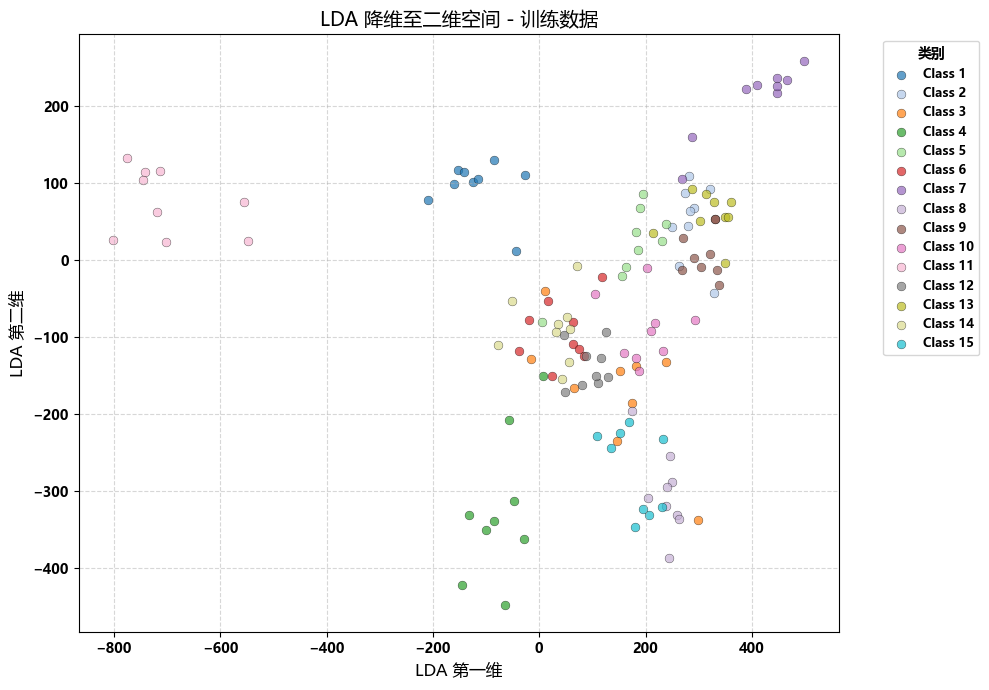

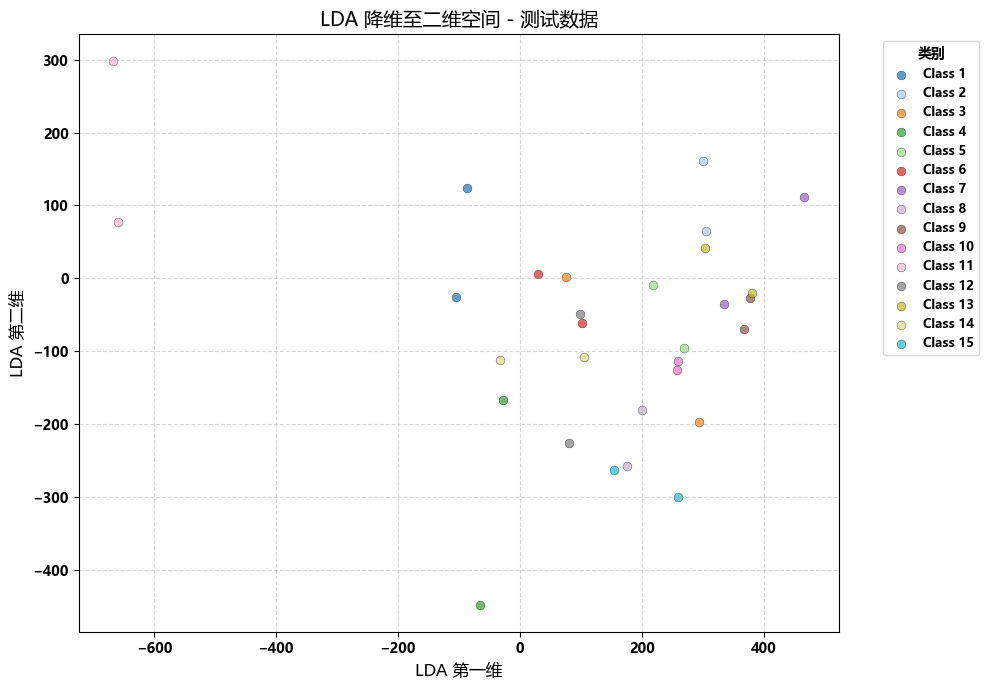

In [9]:
# LDA 降维到 2D 可视化 - 训练数据
lda_2d_train = lda.transform(train_data, dim=2)

plt.figure(figsize=(10, 7))
colors = plt.colormaps.get_cmap('tab20')

for i in range(class_number):
    start = i * train_test_split
    end = (i + 1) * train_test_split
    plt.scatter(lda_2d_train[start:end, 0], lda_2d_train[start:end, 1],
                label=f'Class {i+1}', color=colors(i / class_number), s=40, alpha=0.7, edgecolors='k', linewidths=0.3)

plt.title("LDA 降维至二维空间 - 训练数据", fontsize=14)
plt.xlabel("LDA 第一维", fontsize=12)
plt.ylabel("LDA 第二维", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title="类别")
plt.tight_layout()
plt.savefig("result/lda_2d_train.png", dpi=300)
plt.show()

# LDA 降维到 2D 可视化 - 测试数据
lda_2d_test = lda.transform(test_data, dim=2)

plt.figure(figsize=(10, 7))
for i in range(class_number):
    start = i * (ins_perclass - train_test_split)
    end = (i + 1) * (ins_perclass - train_test_split)
    plt.scatter(lda_2d_test[start:end, 0], lda_2d_test[start:end, 1],
                label=f'Class {i+1}', color=colors(i / class_number), s=40, alpha=0.7, edgecolors='k', linewidths=0.3)

plt.title("LDA 降维至二维空间 - 测试数据", fontsize=14)
plt.xlabel("LDA 第一维", fontsize=12)
plt.ylabel("LDA 第二维", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title="类别")
plt.tight_layout()
plt.savefig("result/lda_2d_test.png", dpi=300)
plt.show()

In [10]:
dims = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]  # 设置需要对比的降维维度
pca_knn_acc = []
lda_knn_acc = []
pca_svm_acc = []
lda_svm_acc = []

In [11]:
# ======================== KNN 分类器 ========================
results = []
knn = KNNClassifier(k=3)

for dim in dims:
    # PCA+KNN 准确率
    train_pca = pca.transform(train_data, dim=dim)
    test_pca = pca.transform(test_data, dim=dim)
    knn.fit(train_pca, train_label)
    acc_pca = knn.score(test_pca, test_label)
    pca_knn_acc.append(acc_pca)
    results.append(f"PCA + KNN Accuracy (dim={dim}): {acc_pca:.4f}")
    print(f"PCA + KNN Accuracy (dim={dim}): {acc_pca:.4f}")

    # LDA+KNN 准确率
    train_lda = lda.transform(train_data, dim=min(dim, class_number - 1))
    test_lda = lda.transform(test_data, dim=min(dim, class_number - 1))
    knn.fit(train_lda, train_label)
    acc_lda = knn.score(test_lda, test_label)
    if dim > class_number - 1:
        lda_knn_acc.append(None)
    else:
        lda_knn_acc.append(acc_lda)
    results.append(f"LDA + KNN Accuracy (dim={min(dim, class_number - 1)}): {acc_lda:.4f}")
    print(f"LDA + KNN Accuracy (dim={min(dim, class_number - 1)}): {acc_lda:.4f}")
    results.append("\n")
# 将结果写入文件
with open("result/accuracy.txt", "w", encoding="utf-8") as f:
    for line in results:
        f.write(line + "\n")

print("所有维度的 KNN 准确率已写入 result/accuracy.txt")

PCA + KNN Accuracy (dim=2): 0.4333
LDA + KNN Accuracy (dim=2): 0.4667
PCA + KNN Accuracy (dim=4): 0.7333
LDA + KNN Accuracy (dim=4): 0.8333
PCA + KNN Accuracy (dim=8): 0.9333
LDA + KNN Accuracy (dim=8): 0.9333
PCA + KNN Accuracy (dim=16): 0.9333
LDA + KNN Accuracy (dim=14): 0.9333
PCA + KNN Accuracy (dim=32): 0.9333
LDA + KNN Accuracy (dim=14): 0.9333
PCA + KNN Accuracy (dim=64): 0.9333
LDA + KNN Accuracy (dim=14): 0.9333
PCA + KNN Accuracy (dim=128): 0.9333
LDA + KNN Accuracy (dim=14): 0.9333
PCA + KNN Accuracy (dim=256): 0.9333
LDA + KNN Accuracy (dim=14): 0.9333
PCA + KNN Accuracy (dim=512): 0.9333
LDA + KNN Accuracy (dim=14): 0.9333
PCA + KNN Accuracy (dim=1024): 0.9333
LDA + KNN Accuracy (dim=14): 0.9333
PCA + KNN Accuracy (dim=2048): 0.9333
LDA + KNN Accuracy (dim=14): 0.9333
所有维度的 KNN 准确率已写入 result/accuracy.txt


In [12]:
# ======================== SVM 分类器 ========================
results = []
svm = SVC(kernel='linear', C=1.0, random_state=42)

for dim in dims:
    # PCA+SVM 准确率
    train_pca = pca.transform(train_data, dim=dim)
    test_pca = pca.transform(test_data, dim=dim)
    svm.fit(train_pca, train_label)
    acc_pca_svm = svm.score(test_pca, test_label)
    pca_svm_acc.append(acc_pca_svm)
    results.append(f"PCA + SVM Accuracy (dim={dim}): {acc_pca_svm:.4f}")
    print(f"PCA + SVM Accuracy (dim={dim}): {acc_pca_svm:.4f}")

    # LDA+SVM 准确率
    train_lda = lda.transform(train_data, dim=min(dim, class_number - 1))
    test_lda = lda.transform(test_data, dim=min(dim, class_number - 1))
    svm.fit(train_lda, train_label)
    acc_lda_svm = svm.score(test_lda, test_label)
    if dim > class_number - 1:
        lda_svm_acc.append(None)
    else:
        lda_svm_acc.append(acc_lda_svm)
    results.append(f"LDA + SVM Accuracy (dim={min(dim, class_number - 1)}): {acc_lda_svm:.4f}")
    print(f"LDA + SVM Accuracy (dim={min(dim, class_number - 1)}): {acc_lda_svm:.4f}")
    results.append("\n")

# 将结果写入文件
with open("result/accuracy.txt", "a", encoding="utf-8") as f:
    for line in results:
        f.write(line + "\n")

print("所有维度的 SVM 准确率已写入 result/accuracy.txt")

PCA + SVM Accuracy (dim=2): 0.3333
LDA + SVM Accuracy (dim=2): 0.4667
PCA + SVM Accuracy (dim=4): 0.5667
LDA + SVM Accuracy (dim=4): 0.8333
PCA + SVM Accuracy (dim=8): 0.8333
LDA + SVM Accuracy (dim=8): 0.9000
PCA + SVM Accuracy (dim=16): 0.9333
LDA + SVM Accuracy (dim=14): 0.9333
PCA + SVM Accuracy (dim=32): 0.9333
LDA + SVM Accuracy (dim=14): 0.9333
PCA + SVM Accuracy (dim=64): 0.9333
LDA + SVM Accuracy (dim=14): 0.9333
PCA + SVM Accuracy (dim=128): 0.9667
LDA + SVM Accuracy (dim=14): 0.9333
PCA + SVM Accuracy (dim=256): 0.9667
LDA + SVM Accuracy (dim=14): 0.9333
PCA + SVM Accuracy (dim=512): 0.9667
LDA + SVM Accuracy (dim=14): 0.9333
PCA + SVM Accuracy (dim=1024): 0.9667
LDA + SVM Accuracy (dim=14): 0.9333
PCA + SVM Accuracy (dim=2048): 0.9667
LDA + SVM Accuracy (dim=14): 0.9333
所有维度的 SVM 准确率已写入 result/accuracy.txt


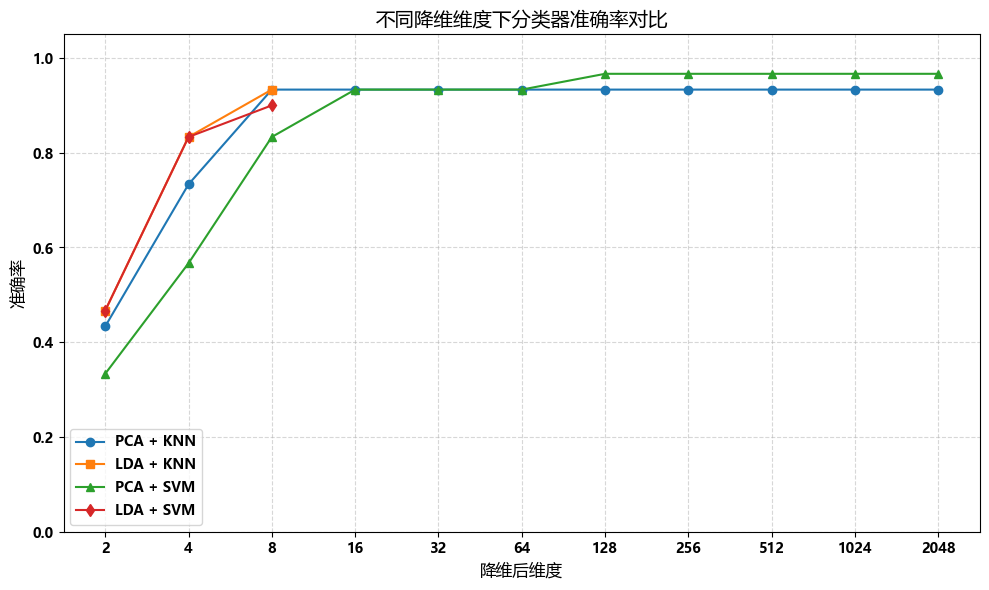

In [13]:
dim_labels = [str(d) for d in dims]

plt.figure(figsize=(10, 6))
plt.plot(dim_labels, pca_knn_acc, marker='o', label='PCA + KNN')
plt.plot(dim_labels, lda_knn_acc, marker='s', label='LDA + KNN')
plt.plot(dim_labels, pca_svm_acc, marker='^', label='PCA + SVM')
plt.plot(dim_labels, lda_svm_acc, marker='d', label='LDA + SVM')

plt.title("不同降维维度下分类器准确率对比", fontsize=14)
plt.xlabel("降维后维度", fontsize=12)
plt.ylabel("准确率", fontsize=12)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("result/accuracy_comparison.png", dpi=300)
plt.show()